<a target="_blank" href="https://colab.research.google.com/github/AI4Finance-Foundation/FinRL-Tutorials/blob/master/1-Introduction/FinRL_Ensemble_StockTrading_ICAIF_2020.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Deep Reinforcement Learning for Stock Trading from Scratch
## Alpha_Dataset_Yearly

# Content

* [1. Problem Definition](#0)
* [2. Getting Started - Load Python packages](#1)
    * [2.1. Check Additional Packages](#1.1)
    * [2.2. Import Packages](#1.2)
    * [2.3. Create Folders & Relevant Configurations¶](#1.3)
* [3. Download Data](#2)
* [4. Preprocess fundamental data](#3)        
    * [4.1. Import the financial data](#3.1)
    * [4.2. Specify items needed to calculate financial ratios](#3.2)
    * [4.3. Sort data based on date and tic columns](#3.3)
    * [4.4. Finish data preparation](#3.4)
* [5.Build Environment](#4)  
    * [5.1. Training & Trade Data Split](#4.1)
    * [5.2. Set up the training environment](#4.2)   
    * [5.3. Initialize Environment](#4.3)    
* [6.Train DRL Agent](#5)  
* [7.Backtest Our Strategy](#6)  
    * [7.1. BackTest with DJIA](#6.1)
    * [7.2. BackTest with Buy&Hold Strategy](#6.2)
* [8.Save & load model](#7)
    * [8.1. Save model](#7.1)
    * [8.2. Load model](#7.2)

<a id='0'></a>
# Part 1. Problem Definition

This problem is to design an automated trading solution for single stock trading. We model the stock trading process as a Markov Decision Process (MDP). We then formulate our trading goal as a maximization problem.

The algorithm is trained using Deep Reinforcement Learning (DRL) algorithms and the components of the reinforcement learning environment are:


* Action: The action space describes the allowed actions that the agent interacts with the
environment. Normally, a ∈ A includes three actions: a ∈ {−1, 0, 1}, where −1, 0, 1 represent
selling, holding, and buying one stock. Also, an action can be carried upon multiple shares. We use
an action space {−k, ..., −1, 0, 1, ..., k}, where k denotes the number of shares. For example, "Buy
10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or −10, respectively

* Reward function: r(s, a, s′) is the incentive mechanism for an agent to learn a better action. The change of the portfolio value when action a is taken at state s and arriving at new state s',  i.e., r(s, a, s′) = v′ − v, where v′ and v represent the portfolio
values at state s′ and s, respectively

* State: The state space describes the observations that the agent receives from the environment. Just as a human trader needs to analyze various information before executing a trade, so
our trading agent observes many different features to better learn in an interactive environment.

* Environment: Dow 30 consituents


The data of the single stock that we will be using for this case study is obtained from Yahoo Finance API. The data contains Open-High-Low-Close price and volume.


<a id='1'></a>
# Part 2. Getting Started- Load Python Packages


<a id='1.1'></a>
## 2.1. Check if the additional packages needed are present, if not install them. 
* Yahoo Finance API
* pandas
* numpy
* matplotlib
* stockstats
* OpenAI gym
* stable-baselines
* tensorflow
* pyfolio

<a id='1.2'></a>
## 2.2. Import Packages

In [1]:
import warnings
warnings.filterwarnings("ignore")

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime
import math
from stable_baselines3.common.logger import configure

%matplotlib inline
# from finrl.config_tickers import SP_500_TICKER
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
# from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.meta.env_portfolio_allocation.env_portfolio import StockPortfolioEnv
from finrl.agents.stablebaselines3.models import DRLAgent
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline

from pprint import pprint

import sys
sys.path.append("../FinRL-Library")

import itertools

<a id='1.3'></a>
## 2.3. Create Folders & Relevant Configurations

In [3]:
import os
from finrl.main import check_and_make_directories
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)

check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])

In [4]:
from datetime import datetime
TEST_END_DATE = datetime.today().strftime('%Y-%m-%d')

TRAIN_START_DATE = '2000-01-01'
TRAIN_END_DATE = '2021-01-01'
TEST_START_DATE = '2021-01-01'
TEST_END_DATE = datetime.today().strftime('%Y-%m-%d')

# Load price data from csv file
tic_dir = './' + DATA_SAVE_DIR + '/sp500_price_monthly.csv'
df = pd.read_csv(tic_dir,index_col=0)

If the data is available locally, we can skip downloading steps and jump directly to part [**4.4.Finish data preparation**](#3.4)

<a id='2'></a>
# Part 3. Download Price Data
Yahoo Finance is a website that provides stock data, financial news, financial reports, etc. All the data provided by Yahoo Finance is free.
* FinRL uses a class **YahooDownloader** to fetch data from Yahoo Finance API
* Call Limit: Using the Public API (without authentication), you are limited to 2,000 requests per hour per IP (or up to a total of 48,000 requests a day).




-----
class YahooDownloader:
    Provides methods for retrieving daily stock data from
    Yahoo Finance API

    Attributes
    ----------
        start_date : str
            start date of the data (modified from config.py)
        end_date : str
            end date of the data (modified from config.py)
        ticker_list : list
            a list of stock tickers (modified from config.py)

    Methods
    -------
    fetch_data()
        Fetches data from yahoo API


In [5]:
# Download data from YFinance
# tic_dir = './' + DATA_SAVE_DIR + '/sp500_ticker.csv'
# tic_list = pd.read_csv(tic_dir,index_col=0)
# SP_500_TICKER = np.array(tic_list.tic).tolist()
# df = YahooDownloader(start_date = TRAIN_START_DATE,
#                      end_date = TEST_END_DATE,
#                      ticker_list = SP_500_TICKER).fetch_data()

In [6]:
# df.head()

In [7]:
# df.tail()

In [8]:
# df.shape

In [9]:
# df.sort_values(['date','tic']).head()

In [10]:
# len(df.tic.unique())

In [11]:
# df.tic.value_counts()

<a id='3'></a>
# Part 4: Preprocess fundamental data
- Import finanical data downloaded from Alpha Vantage
- Preprocess the dataset and calculate financial ratios
- Turn yearly ratio into daily basis

<a id='3.1'></a>
## 4.1 Import the financial data

#### Define configurations of the collecting data & download data via Alpha Vantage API

In [12]:
# import requests

# api_key = 'GZWRUSYXT18ZTR6C'
# features_cols = ['fiscalDateEnding','totalRevenue','costOfRevenue','sellingGeneralAndAdministrative','researchAndDevelopment','depreciation','interestExpense','totalCurrentLiabilities','incomeTaxExpense','netIncome','commonStockSharesOutstanding','cashAndCashEquivalentsAtCarryingValue','cashAndShortTermInvestments','operatingCashflow','totalLiabilities','inventory','currentNetReceivables','propertyPlantEquipment','capitalExpenditures','longTermInvestments','totalShareholderEquity','longTermDebt','retainedEarnings','dividendPayoutCommonStock','paymentsForRepurchaseOfCommonStock','treasuryStock','currentLongTermDebt']
# price_cols = ['open','high','low','close','volume']

Function to download fundamental data from financial reports by ticket

In [13]:
# def collect_fundamental(ticket):
#     # Download income statement
#     url = f'https://www.alphavantage.co/query?function=INCOME_STATEMENT&symbol={ticket}&apikey={api_key}'
#     r = requests.get(url)
#     data_is = r.json()

#     # Download balance sheet
#     url = f'https://www.alphavantage.co/query?function=BALANCE_SHEET&symbol={ticket}&apikey={api_key}'
#     r = requests.get(url)
#     data_bs = r.json()

#     # Download cash flow
#     url = f'https://www.alphavantage.co/query?function=CASH_FLOW&symbol={ticket}&apikey={api_key}'
#     r = requests.get(url)
#     data_cf = r.json()

#     df_is = pd.json_normalize(data_is['annualReports'])
#     df_bs = pd.json_normalize(data_bs['annualReports'])
#     df_cf = pd.json_normalize(data_cf['annualReports'])

#     merged_df = df_is.merge(df_bs).merge(df_cf)
#     merged_df['tic'] = ticket
#     merged_df = merged_df[['tic']+features_cols]
#     merged_df['fiscalDateEnding'] = pd.to_datetime(merged_df.fiscalDateEnding,format='mixed')

#     return merged_df

Function to download stock price by ticket

In [14]:
# def collect_price(ticket):
#     url = f'https://www.alphavantage.co/query?function=TIME_SERIES_MONTHLY&symbol={ticket}&apikey={api_key}'
#     r = requests.get(url)
#     data_monthly_price = r.json()

#     price_monthly = pd.DataFrame.from_dict(data_monthly_price['Monthly Time Series'], orient='index')
#     price_monthly.columns = price_cols
#     price_monthly['fiscalDateEnding'] = pd.to_datetime(price_monthly.index,format='mixed')
#     price_monthly.reset_index(inplace=True,drop=True)
#     price_monthly = price_monthly[['fiscalDateEnding','open','high','low','close','volume']]
#     return price_monthly

Function to merge monthly stock price into yearly fundamental data

In [15]:
# def merge_price_to_df(merged_df,price_monthly):
#     merged_df['year'] = merged_df.fiscalDateEnding.dt.year
#     merged_df['month'] = merged_df.fiscalDateEnding.dt.month
#     price_monthly['year'] = price_monthly.fiscalDateEnding.dt.year
#     price_monthly['month'] = price_monthly.fiscalDateEnding.dt.month
#     merged_final = pd.merge(merged_df,price_monthly,how="left",on=['year','month'])
#     merged_final.drop(columns=['year','month','fiscalDateEnding_y'],inplace=True)
#     merged_final = df_final.rename(columns={'fiscalDateEnding_x': 'date'})
#     merged_final['tic'] = ticket

#     merged_columns = [merged_final.columns[-1]]
#     for i in range(0,len(merged_final.columns)-1):
#         merged_columns.append(merged_final.columns[i])
#     merged_final = merged_final[merged_columns]
    
#     return merged_final

In [16]:
# download_tics = SP_500_TICKER[453:]
# print(download_tics)

In [17]:
# fund_data = pd.DataFrame()

# for ticket in download_tics:
#     df_fund = collect_fundamental(ticket)
#     fund_data = pd.concat([fund_data, df_fund], ignore_index=True)

In [18]:
# fund_data.to_csv('sp500_6.csv')

In [19]:
# Check dropped tickers which are not available data to download from Alpha Vantage

# tics_1 = pd.DataFrame()
# tics_2 = pd.DataFrame()
# tics_1['tic'] = df.tic.unique()
# tics_2['tic'] = fund_data.tic.unique()

# merged_df = tics_1.merge(tics_2, how='outer', indicator=True)
# unique_in_df = merged_df[merged_df['_merge'] == 'left_only']
# unique_in_df

#### Check reach download limitation

In [20]:
# url = f'https://www.alphavantage.co/query?function=INCOME_STATEMENT&symbol=IBM&apikey=GZWRUSYXT18ZTR6C'
# r = requests.get(url)
# data_is = r.json()
# data_is

#### Load data from csv file

In [21]:
# fund_data = pd.read_csv('./' + DATA_SAVE_DIR + '/sp500_fundamental.csv',index_col=0)
# # fund_data = fund_data.rename(columns={'fiscalDateEnding_x':'date'})
# fund_data['date'] = pd.to_datetime(fund_data.date,format='mixed')
# fund_data

In [22]:
# UTIL TOOL: merge yearly fundamental data to daily stock price

# start_date = df.iloc[0].date
# end_date = df.iloc[-1].date
# date_range = pd.date_range(start=start_date, end=end_date, freq='D')
# date_range = pd.DataFrame(date_range)
# date_range.columns = ['date']

# fund_data = fund_data.rename(columns={'fiscalDateEnding':'date'})
# fund_data['date'] = pd.to_datetime(fund_data.date,format='mixed')

# fund_data_with_price = pd.DataFrame()
# for ticket in fund_data.tic.unique():
#     price_by_ticket = df[df.tic == ticket]
#     price_by_ticket['date'] = pd.to_datetime(price_by_ticket['date'],format='mixed')
#     price_by_ticket = pd.merge(date_range,price_by_ticket,how='left')
#     price_by_ticket.bfill(inplace=True)
#     price_by_ticket = pd.merge(fund_data.loc[fund_data.tic==ticket],price_by_ticket,how='left',on=['date'])
#     price_by_ticket.drop(columns=['tic_y','day'],inplace=True,axis=0)
#     price_by_ticket = price_by_ticket.rename(columns={'tic_x':'tic'})
#     fund_data_with_price = pd.concat([fund_data_with_price, price_by_ticket], ignore_index=True)

#### Data cleaning ####
Refine the data before computing fundamental ratios

In [23]:
# print(fund_data.info(),'\n')
# print(fund_data.isna().sum())

The company with zero totalRevenue might cause problems for computing ratios while it is the denominator in some formulars.<br>
Deleting all tickers containing this issue is a good solution.

In [24]:
# zero_revenue_tics = fund_data[fund_data.totalRevenue == 0].tic.unique()
# fund_data = fund_data[~fund_data.tic.isin(zero_revenue_tics)]
# fund_data[fund_data.totalRevenue == 0]

While removing zero revenue data was neccessary, other columns with zero values might indicate some potential issues that require further investigations

In [25]:
# column_nan = fund_data.eq(0).any()
# column_nan

In [26]:
# fund_data = fund_data.fillna(0)
# for i in fund_data.columns:
#     print(i,'\n',fund_data[i].unique(),'\n')

'None' value is replaced with '0' and correcting datatype can now being apply on the features. In this case, all data points must be turned into float instead of object.

In [27]:
# float_columns = fund_data.columns
# float_columns = float_columns.drop(['date','tic'])

# for column in float_columns:
#     fund_data[column] = fund_data[column].astype(float)

# fund_data.info()

## 4.2 Compute fundamental ratio

Define support functions before computing fundamental ratios

In [28]:
# # # Define a function to count positive values within a window
# def count_positives(window):
#   return window[window > 0].count()

# def count_positives_window(data,k):
#     df = pd.DataFrame(data, columns=['values'])

#     # Create a new column with the adjusted positive count (using a shifted window)
#     df['positive_count'] = df['values'].rolling(window=k, min_periods=1).apply(count_positives)

#     # Set positive_count of the first k rows to positive_count of row k
#     df.loc[:k-1,'positive_count'] = df.loc[k-1].positive_count

#     return df

In [29]:
# # # Define a function to min value within a window
# def get_min(window):
#   return window.min()

# def min_in_window(data,k):
#     df = pd.DataFrame(data, columns=['values'])

#     # Create a new column with the min in the window (using a shifted window)
#     df['min'] = df['values'].rolling(window=k, min_periods=1).apply(get_min)

#     return df

At this point, data and supporting functions are ready for computing fundamental ratios required

In [30]:
# def compute_fund_ratios(df_final):
#     pos_count_window = 10  # number of years to look back for count_positive_profit
#     min_ebit_window = 4  # number of years to look back for min_ebit
    
#     gross_income = df_final.totalRevenue - df_final.costOfRevenue
#     ebit = gross_income - df_final.sellingGeneralAndAdministrative
#     profit = ebit - df_final.interestExpense - df_final.incomeTaxExpense
#     market_equity = df_final.commonStockSharesOutstanding * df_final.close
#     market_asset = df_final.totalLiabilities + market_equity
    
#     # Gross profit margin
#     gross_profit_margin = (gross_income/df_final.totalRevenue).to_frame('gross_profit_margin')
    
#     # SGA Expense / Gross Profit
#     sga_ratio = (df_final.sellingGeneralAndAdministrative/gross_income).to_frame('sga_ratio')
    
#     # Depreciation / Gross Profit
#     dep_ratio = (df_final.depreciation/gross_income).to_frame('dep_ratio')
    
#     # EBIT / Bond interest
#     ebit_on_int = (ebit/df_final.interestExpense).to_frame('ebit_on_int')
    
#     # Profit margin
#     profit_margin = (profit/df_final.totalRevenue).to_frame('profit_margin')
    
#     # Amount of positive profit within a window
#     count_positive_profit = count_positives_window(profit,pos_count_window)
#     count_positive_profit = count_positive_profit['positive_count'].to_frame('count_positive_profit')
    
#     # Cash And Short Term Investments / Total Liabilities
#     csti_on_liabilities = (df_final.cashAndShortTermInvestments/df_final.totalLiabilities).to_frame('csti_on_liabilities')
    
#     # Inventory / EBIT
#     inventory_on_ebit = (df_final.inventory / ebit).to_frame('inventory_on_ebit')
    
#     # Receivable / Revenue
#     receivable_on_rev = (df_final.currentNetReceivables / df_final.totalRevenue).to_frame('receivable_on_rev')
    
#     # ROA
#     roa = (profit / market_asset).to_frame('roa')
    
#     # ROE
#     roe = (profit / market_equity).to_frame('roe')
    
#     # Long-term debt / minEBIT
#     min_ebit = min_in_window(ebit,min_ebit_window)['min']
#     debt_on_min_ebit = (df_final.longTermDebt / min_ebit).to_frame('debt_on_min_ebit')
    
#     # Total Liabilities / Total Equity
#     liabilities_on_equity = (df_final.totalLiabilities / market_equity).to_frame('liabilities_on_equity')
    
#     # Capital Expenditures / EBIT
#     capital_cost_on_ebit = (df_final.capitalExpenditures / ebit).to_frame('capital_cost_on_ebit')
    
#     # EPS / MP
#     eps = profit / df_final.commonStockSharesOutstanding
#     eps_on_mp = (eps / df_final.close).to_frame('eps_on_mp')
    
#     # Cash and Stock Dividend & Repurchase Common / MP
#     dividend_on_mp = ((df_final.dividendPayoutCommonStock + df_final.paymentsForRepurchaseOfCommonStock) / df_final.close).to_frame('dividend_on_mp')
    
#     # MP / BV
#     mp_on_bv = (df_final.close / (df_final.cashAndShortTermInvestments + df_final.currentNetReceivables*0.8 +df_final.inventory*0.5 + df_final.propertyPlantEquipment*0.2 + df_final.longTermInvestments - df_final.totalLiabilities)).to_frame('mp_on_bv')

#     # Create a dataframe that merges all the ratios
#     ratios = pd.concat([df_final.date,df_final.tic,df_final.close,gross_profit_margin,sga_ratio,dep_ratio,
#                     ebit_on_int,profit_margin,count_positive_profit,csti_on_liabilities,
#                     inventory_on_ebit,receivable_on_rev,roa,roe,debt_on_min_ebit,
#                    liabilities_on_equity,capital_cost_on_ebit,eps_on_mp,dividend_on_mp,mp_on_bv], axis=1)

#     return ratios

In [31]:
# ratios = compute_fund_ratios(fund_data)
# ratios.head()

In [32]:
# # Check columns with inf values

# check_ratios = ratios[ratio_list]
# inf_cols = check_ratios.columns[~np.isfinite(check_ratios).all()]
# inf_cols

In [33]:
# Check rows with inf values

# print(f'{ratios.info()}\n')
# print(ratios.isna().sum())

# ratio_inf = ratios.isin([np.inf,-np.inf])
# filtered_inf = ratio_inf[(ratio_inf == True).any(axis=1)]
# print(len(filtered_inf))

# ratio_list = ratios.columns.drop(['date','tic','close'])
# count_inf = np.isinf(ratios[ratio_list]).values.sum()

# ratio_inf = ratios[((ratios == np.inf)|(ratios == -np.inf)).any(axis=1)]
# print(len(ratios[((ratios == np.inf)|(ratios == -np.inf)).any(axis=1)]))

The **ebit_on_int** has infinity values for companies without banking support. We need to address these cases separately: <br>
 * Replace positive inf with maximum value in ebit_on_int
 * Replace negative inf with minimum value in ebit_on_int

In [34]:
# ratio_finite = ratios[~((ratios == np.inf)|(ratios == -np.inf)).any(axis=1)]
# ratios['ebit_on_int'] = ratios.ebit_on_int.replace(np.inf,ratio_finite.ebit_on_int.max())
# ratios['ebit_on_int'] = ratios.ebit_on_int.replace(-np.inf,ratio_finite.ebit_on_int.min())
# print(len(ratios[((ratios == np.inf)|(ratios == -np.inf)).any(axis=1)]))

While data processing greatly reduces the number of inf values, some still remain.<br>
Since the remain inf values represent a small portion of the data, we can safely remove the corresponding rows

In [35]:
# check_ratios = ratios[ratio_list]
# inf_cols = check_ratios.columns[~np.isfinite(check_ratios).all()]
# inf_cols

In [36]:
# ratios = ratios[~((ratios == np.inf)|(ratios == -np.inf)).any(axis=1)]
# ratios.reset_index(inplace=True,drop=True)
# ratios

<a id='3.3'></a>
## 4.3 Sort dataset based on date and tic columns
The data is prepared for training, however the data points are not ordered chronologically.<br>
This step ensure the agent travel through the data in a year-by-year order.

In [37]:
# processed_full = ratios.sort_values(by=['date','tic']).reset_index(drop=True)
# processed_full

In [38]:
# processed_full.to_csv('./' + DATA_SAVE_DIR + '/sp500_ready_data_yearly.csv')

<a id='3.4'></a>
## 4.4 Finish data preparation

In [39]:
# processed_full = final_ratios.copy()

# If the data is available in the data storage, load processed_full from readied data
processed_full = pd.read_csv('./' + DATA_SAVE_DIR + '/sp500_ready_data_yearly.csv',index_col=0)
processed_full['date'] = pd.to_datetime(processed_full.date,format='mixed')

In [40]:
processed_full.replace([np.inf, -np.inf], np.nan, inplace=True)
processed_full = processed_full.fillna(0)
print(processed_full.isna().sum())

date                     0
tic                      0
close                    0
gross_profit_margin      0
sga_ratio                0
dep_ratio                0
ebit_on_int              0
profit_margin            0
count_positive_profit    0
csti_on_liabilities      0
inventory_on_ebit        0
receivable_on_rev        0
roa                      0
roe                      0
debt_on_min_ebit         0
liabilities_on_equity    0
capital_cost_on_ebit     0
eps_on_mp                0
dividend_on_mp           0
mp_on_bv                 0
dtype: int64


Reset **TRAIN_START_DATE** and **TEST_END_DATE**

In [41]:
TRAIN_START_DATE = processed_full.date.min().strftime("%Y-%m-%d")
TEST_END_DATE = processed_full.date.max().strftime("%Y-%m-%d")
print('TRAIN_START_DATE: ',TRAIN_START_DATE,'\n')
print('TRAIN_END_DATE: ',TRAIN_END_DATE,'\n')
print('TEST_START_DATE: ',TEST_START_DATE,'\n')
print('TEST_END_DATE: ',TEST_END_DATE,'\n')

TRAIN_START_DATE:  2009-09-30 

TRAIN_END_DATE:  2021-01-01 

TEST_START_DATE:  2021-01-01 

TEST_END_DATE:  2024-02-03 



<a id='4'></a>
# Part 5. Design Environment
Considering the stochastic and interactive nature of the automated stock trading tasks, a financial task is modeled as a **Markov Decision Process (MDP)** problem. The training process involves observing stock price change, taking an action and reward's calculation to have the agent adjusting its strategy accordingly. By interacting with the environment, the trading agent will derive a trading strategy with the maximized rewards as time proceeds.

Our trading environments, based on OpenAI Gym framework, simulate live stock markets with real market data according to the principle of time-driven simulation.

The action space describes the allowed actions that the agent interacts with the environment. Normally, action a includes three actions: {-1, 0, 1}, where -1, 0, 1 represent selling, holding, and buying one share. Also, an action can be carried upon multiple shares. We use an action space {-k,…,-1, 0, 1, …, k}, where k denotes the number of shares to buy and -k denotes the number of shares to sell. For example, "Buy 10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or -10, respectively. The continuous action space needs to be normalized to [-1, 1], since the policy is defined on a Gaussian distribution, which needs to be normalized and symmetric.

<a id='4.1'></a>
## 5.1 Training & Trade Data Split
- Training data period: 2009-01-01 to 2020-01-01
- Trade data period: 2020-01-01 to 2023-12-29

In [42]:
train_data = data_split(processed_full, TRAIN_START_DATE, TRAIN_END_DATE)
trade_data = data_split(processed_full, TEST_START_DATE, TEST_END_DATE)
# Check the length of the two datasets
print(len(train_data))
print(len(trade_data))

5251
1483


In [43]:
train_data = train_data.reset_index(drop=True)
train_data

,date,tic,close,gross_profit_margin,sga_ratio,dep_ratio,ebit_on_int,profit_margin,count_positive_profit,csti_on_liabilities,inventory_on_ebit,receivable_on_rev,roa,roe,debt_on_min_ebit,liabilities_on_equity,capital_cost_on_ebit,eps_on_mp,dividend_on_mp,mp_on_bv
0,2009-09-30,AAPL,5.604187,0.304696,0.317372,0.000000,27.374233,0.111106,10.0,1.479352,0.050986,0.078336,0.228046,0.945331,0.000000,3.145352,0.128194,0.945331,0.000000e+00,2.618375e-10
1,2009-09-30,APD,50.297554,0.103254,1.123229,0.971425,-0.849057,-0.050490,5.0,0.060278,-4.923671,0.167587,-0.021933,-0.038651,-10.575235,0.762205,-11.392271,-0.038651,7.421832e+06,-1.249467e-08
2,2009-09-30,BDX,53.350754,0.283421,0.832864,0.154761,8.351160,-0.016058,3.0,0.467527,3.429526,0.164127,-0.006757,-0.008962,-14.966166,0.326203,1.752481,-0.008962,1.624875e+07,-4.873523e-07
3,2009-09-30,BEN,20.057692,0.296393,0.864485,0.000000,44.671970,-0.052366,7.0,2.580349,3.733393,0.138721,-0.034486,-0.047748,0.000000,0.384568,0.268215,-0.047748,2.840262e+07,4.786678e-09
4,2009-09-30,EMR,26.482727,0.151422,1.394380,0.171456,-5.677273,-0.103132,3.0,0.139186,-1.485188,0.173225,-0.069313,-0.108329,-3.654123,0.562887,0.425140,-0.108329,6.479695e+07,-5.170287e-09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5246,2020-12-31,YUM,102.310020,0.462668,0.488337,0.000000,2.385027,0.116950,10.0,0.053118,0.000000,0.100672,0.014807,0.021393,15.989537,0.444791,0.119581,0.021393,7.868242e+06,-8.331571e-09
5247,2020-12-31,ZBH,146.273346,-0.028587,-13.975786,-1.990211,-13.711321,-0.445204,6.0,0.065647,-0.843092,0.213956,-0.070983,-0.099544,-3.137127,0.402363,-0.040422,-0.099544,1.357048e+06,-1.697074e-08
5248,2020-12-31,ZBRA,384.329987,0.217252,0.831045,0.071806,2.105263,0.006423,9.0,0.075828,3.193750,0.120211,0.001179,0.001365,151.272727,0.157482,0.418750,0.001365,5.203861e+05,-1.703213e-07
5249,2020-12-31,ZION,38.849308,-2.805100,-0.147403,-0.000000,-11.625000,-3.737705,1.0,0.021972,4.474250,0.000000,-0.025660,-0.321893,-0.677485,11.544393,-0.096774,-0.321893,8.623062e+06,-6.680166e-10


In [44]:
trade_data = trade_data.reset_index(drop=True)
trade_data

,date,tic,close,gross_profit_margin,sga_ratio,dep_ratio,ebit_on_int,profit_margin,count_positive_profit,csti_on_liabilities,inventory_on_ebit,receivable_on_rev,roa,roe,debt_on_min_ebit,liabilities_on_equity,capital_cost_on_ebit,eps_on_mp,dividend_on_mp,mp_on_bv
0,2021-01-29,DG,188.258728,0.101251,2.106047,0.167358,-25.018566,-0.138769,1.0,0.071692,-1.394709,0.002701,-0.072246,-0.102849,-0.911556,0.423592,-0.273219,-0.102849,1.499192e+07,-1.312048e-08
1,2021-01-29,LOW,157.945999,0.088005,2.401296,0.194426,-12.397936,-0.154988,8.0,0.114707,-1.497826,0.000000,-0.084519,-0.117679,-3.926001,0.392331,-0.165665,-0.117679,4.226128e+07,-5.646070e-09
2,2021-01-30,BBWI,32.094421,0.073265,1.793269,0.626202,-1.527778,-0.118792,0.0,0.319055,-0.866667,0.023688,-0.063767,-0.151195,-7.480611,1.371067,-0.345455,-0.151195,2.586119e+06,-4.208884e-09
3,2021-01-30,BBY,95.633957,0.223710,0.749834,0.071787,50.865385,0.042614,10.0,0.379420,2.121739,0.022449,0.051564,0.081943,0.733642,0.589147,0.269565,0.081943,9.201752e+06,-1.960034e-08
4,2021-01-30,DLTR,100.860001,0.305277,0.757685,0.081041,589.687500,0.058249,10.0,0.105640,1.907631,0.000000,0.040214,0.063125,1.792333,0.569722,0.476312,0.063125,4.134444e+06,-1.076312e-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1478,2023-12-31,ZTS,196.125183,0.415964,0.605234,0.086100,5.870293,0.066479,10.0,0.219580,1.827512,0.159410,0.005726,0.006318,6.550249,0.103396,0.521739,0.006318,9.096231e+06,-4.623849e-08
1479,2024-01-28,HD,353.585266,0.333794,0.521939,0.059262,12.538343,0.115531,7.0,0.049811,0.861013,0.021799,0.041380,0.050286,4.355689,0.215209,0.132419,0.050286,4.619536e+07,-6.628299e-09
1480,2024-01-28,NVDA,624.620728,0.727176,0.059908,0.020180,162.050584,0.612784,10.0,1.142154,0.126828,0.164128,0.023903,0.024256,3.124879,0.014782,0.025668,0.024256,1.589445e+07,3.854970e-08
1481,2024-01-31,CRM,280.723297,0.171212,2.581407,0.000000,-325.551724,-0.294932,9.0,0.355278,-0.000000,0.327339,-0.032882,-0.037728,-0.998411,0.147394,-0.077958,-0.037728,2.989421e+07,-2.463176e-08


<a id='4.2'></a>
## 5.2 Set up the training environment

Describe the environment

In [45]:
import gymnasium as gym
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from gymnasium import spaces
from gymnasium.utils import seeding
from stable_baselines3.common.vec_env import DummyVecEnv
# from gym.spaces import Box

matplotlib.use("Agg")

# from stable_baselines3.common import logger


class StockTradingEnv(gym.Env):
    """A stock trading environment for OpenAI gym"""

    metadata = {"render.modes": ["human"]}

    def __init__(
        self,
        df,
        # stock_dim,
        hmax,
        initial_amount,
        buy_cost_pct,
        sell_cost_pct,
        reward_scaling,
        state_space,
        action_space,
        tech_indicator_list,
        stop_loss,
        punishment_rate,
        make_plots=False,
        print_verbosity=10,
        row=0,
        initial=True,
        previous_state=[],
        model_name="",
        mode="",
        iteration="",
    ):
        # self.row = row
        self.df = df
        # self.stock_dim = stock_dim
        self.hmax = hmax
        self.initial_amount = initial_amount
        self.buy_cost_pct = buy_cost_pct
        self.sell_cost_pct = sell_cost_pct
        self.reward_scaling = reward_scaling
        self.state_space = state_space
        self.action_space = action_space
        self.tech_indicator_list = tech_indicator_list
        self.punishment_rate = punishment_rate
        self.stop_loss = stop_loss # the game stops when the asset loses more than stop_loss percent
        self.action_space = spaces.Box(low=-1, high=1, shape=(self.action_space,))
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf, shape=(self.state_space,)
        )
        # self.data = self.df.loc[self.row, :]
        self.terminal = False
        self.make_plots = make_plots
        self.print_verbosity = print_verbosity
        # self.turbulence_threshold = turbulence_threshold
        # self.risk_indicator_col = risk_indicator_col
        self.initial = initial
        self.previous_state = previous_state
        self.model_name = model_name
        self.mode = mode
        self.iteration = iteration
        self.portfolio_columns = ['tic','price','buy_price','amount','weight']
        self.row = 0
        
        # initalize state
        self.state = self._initiate_state()

        # initialize reward
        self.reward = 0
        self.turbulence = 0
        self.cost = 0
        self.trades = 0
        self.episode = 0
        
        # memorize all the total balance change
        self.asset_memory = [self.initial_amount]
        self.rewards_memory = []
        self.actions_memory = []
        self.date_memory = [self._get_date()]
        # self.reset()
        self._seed()

    def _buy_stock(self, action):
        def _do_buy():
            if self.data.close > 0: # Buy only if the price is > 0 (no missing data in this particular date)
                buy_amount = (self.portfolio.loc[0].price * action)
                buy_num_shares = math.floor(buy_amount/self.data.close)
                if buy_num_shares > 0:
                    if self.portfolio[self.portfolio.tic == self.data.tic].empty:
                        selected_index = len(self.portfolio)
                        selected_row = [self.data.tic,0,self.data.close,0,0]
                    else:
                        selected_index = self.portfolio[self.portfolio.tic == self.data.tic].index[0]
                        selected_row = self.portfolio.loc[selected_index]
                        selected_row[2] = (buy_num_shares*self.data.close + selected_row[2]*selected_row[3]) \
                                    /(buy_num_shares + selected_row[3])
                    selected_row[1] = self.data.close
                    selected_row[3] += buy_num_shares
                    self.portfolio.loc[selected_index] = selected_row
    
                    # Update remain capital
                    capital_row = self.portfolio.loc[0]
                    capital_change = buy_num_shares * self.data.close * (1 + self.buy_cost_pct)
                    capital_row[1] -= capital_change
                    capital_row[2] -= capital_change
                    self.portfolio.loc[0] = capital_row
                    
                    self._compute_weight()
                    self.cost += selected_row[1] * buy_num_shares * self.buy_cost_pct
                    self.trades += 1
                else:
                    # Punish a certain amount of money if buying without avaiable capital
                    self.reward = -1 * self.initial_amount * self.punishment_rate
                    # print(f'Set punishment for unavailable buying: {self.reward}')
                    
            else:
                buy_num_shares = 0

            return buy_num_shares

        buy_num_shares = _do_buy()
        return buy_num_shares
    
    def _sell_stock(self, action):
        def _do_sell_normal():
            # TODO: Punish a certain amount of money if selling without avaiable stock in the inventory
            if self.data.close > 0: # Sell only if the price is > 0 (no missing data in this particular date)
                # perform sell action based on the sign of the action
                if self.portfolio[self.portfolio.tic == self.data.tic].empty:            
                    sell_num_shares = 0
                    
                    # Punish a certain amount of money if selling without avaiable stock in the inventory
                    self.reward = -1 * self.initial_amount * self.punishment_rate
                
                else:
                    sell_num_shares = math.floor(abs(action) * self.portfolio[self.portfolio.tic == self.data.tic].amount) 
                    sell_amount = self.data.close * sell_num_shares * (1 - self.sell_cost_pct)

                    # Update reward only when closing a deal
                    # buy_amount = self.portfolio[self.portfolio.tic == self.data.tic].buy_price * sell_num_shares
                    # self.reward = (sell_amount - buy_amount).values[0].item()
                    
                    # update stock row in the portfolio
                    selected_index = self.portfolio[self.portfolio.tic == self.data.tic].index[0]
                    selected_row = self.portfolio.loc[selected_index]
                    selected_row[1] = self.data.close
                    selected_row[3] -= sell_num_shares

                    # Update remain capital
                    capital_row = self.portfolio.loc[0]
                    capital_row[1] += sell_amount
                    capital_row[2] += sell_amount

                    # Update changes to portfolio
                    self.portfolio.loc[selected_index] = selected_row
                    self.portfolio.loc[0] = capital_row
                    self._compute_weight()
                    self.cost += selected_row[1] * sell_num_shares * self.sell_cost_pct
                    self.trades += 1
            else:
                sell_num_shares = 0

            return sell_num_shares

        sell_num_shares = _do_sell_normal()
        return sell_num_shares

    def _compute_weight(self):
        nav = sum(self.portfolio.price*self.portfolio.amount)
        self.portfolio['weight'] = self.portfolio.apply(lambda x: x.price * x.amount / nav, axis=1)
    
    # def _make_plot(self):
    #     plt.plot(self.asset_memory, "r")
    #     plt.savefig("results/account_value_trade_{}.png".format(self.episode))
    #     plt.close()

    def step(self, actions):

        current_total_asset = sum(self.portfolio.price * self.portfolio.amount)
        self.terminal = (self.row >= len(self.df.index.unique()) - 1) | (current_total_asset < self.initial_amount*(1-self.stop_loss))
        # print(f'Action of step {self.row} is {actions[0]}')
        
        # --> IN CASE THE STEP IS THE TERMINATED STEP
        if self.terminal: 
            print(f"Episode: {self.episode}")
            # if self.make_plots:
            #     self._make_plot()
                
            # Summary the training performance after an episode
            end_total_asset = sum(self.portfolio.price*self.portfolio.amount)
            tot_reward = end_total_asset - self.initial_amount

            # Summary total_value
            # df_total_value = pd.DataFrame(self.asset_memory)
            # df_total_value.columns = ["account_value"]
            # df_total_value["date"] = self.date_memory
            # df_total_value["daily_return"] = df_total_value["account_value"].pct_change(1)
            # if df_total_value["daily_return"].std() != 0:
            #     sharpe = ((252 ** 0.5)* df_total_value["daily_return"].mean()/ df_total_value["daily_return"].std())

            # Take tot_reward into account
            self.reward = tot_reward
            self.rewards_memory.append(self.reward)
            self.reward = self.reward * self.reward_scaling
            
            # Summary rewards
            # df_rewards = pd.DataFrame(self.rewards_memory)
            # df_rewards.columns = ["account_rewards"]
            # df_rewards["date"] = self.date_memory[:-1]

            # Print out training results after a certain amount of episodes
            if self.episode % self.print_verbosity == 0:
                print(f"row: {self.row}, episode: {self.episode}")
                print(f"begin_total_asset: {self.asset_memory[0]:0.2f}")
                print(f"end_total_asset: {end_total_asset:0.2f}")
                print(f"total_reward: {tot_reward:0.2f}")
                print(f"total_cost: {self.cost:0.2f}")
                print(f"total_trades: {self.trades}")
                # if df_total_value["daily_return"].std() != 0:
                #     print(f"Sharpe: {sharpe:0.3f}")
                print("=================================")

            # if (self.model_name != "") and (self.mode != ""):
                # df_actions = self.save_action_memory()
                # df_actions.to_csv(
                #     "results/actions_{}_{}_{}.csv".format(
                #         self.mode, self.model_name, self.iteration
                #     )
                # )
                # df_total_value.to_csv(
                #     "results/account_value_{}_{}_{}.csv".format(
                #         self.mode, self.model_name, self.iteration
                #     ),
                #     index=False,
                # )
                # df_rewards.to_csv(
                #     "results/account_rewards_{}_{}_{}.csv".format(
                #         self.mode, self.model_name, self.iteration
                #     ),
                #     index=False,
                # )
                # plt.plot(self.asset_memory, "r")
                # plt.savefig(
                #     "results/account_value_{}_{}_{}.png".format(
                #         self.mode, self.model_name, self.iteration
                #     ),
                #     index=False,
                # )
                # plt.close()
            
            truncated = False  # we do not limit the number of steps here
            # Optionally we can pass additional info, we are not using that for now
            info = {}


            return (
                np.array(self.state).astype(np.float32),
                self.reward,
                self.terminal,
                truncated,
                info,
            )

        # --> IN A NORMAL STEP
        else: 

            # begin_total_asset = sum(self.portfolio.price * self.portfolio.amount)
            
            # update previous_portfolio
            self.previous_port = self.portfolio.copy()
        
            # sell_number_share = 0 # Default value at each transaction to detect reward value
            self.reward = 0
            if actions[0] > 0:
                self._buy_stock(actions[0])
            else:
                sell_number_share = self._sell_stock(actions[0])

            # actions = actions * self.hmax  # actions initially is scaled between 0 to 1
            # actions = actions.astype(int)  # convert into integer because we can't by fraction of shares
            # print(type(actions))
            self.actions_memory.append(actions)

            # Update selected row in the dataset based on state: s -> s+1
            self.row += 1
            self.data = self.df.loc[self.row]
            self.state = self._update_state()
    
            end_total_asset = sum(self.portfolio.price * self.portfolio.amount)
            # print(f'Begin asset: {begin_total_asset}, End asset: {end_total_asset}')

            # Update asset memory
            self.asset_memory.append(end_total_asset)
            self.date_memory.append(self._get_date())

            # Update reward
            self.reward = end_total_asset - self.initial_amount
            self.rewards_memory.append(self.reward)
            self.reward = self.reward * self.reward_scaling

        truncated = False  # we do not limit the number of steps here
        # Optionally we can pass additional info, we are not using that for now
        info = {}
        
        # return self.state, self.reward, self.terminal, {}
    
        return (
            np.array(self.state).astype(np.float32),
            self.reward,
            self.terminal,
            truncated,
            info,
        )

    def reset(self, seed=None, options=None):
        # initiate state
        self.state = self._initiate_state()

        # Reset asset_memory
        if self.initial:
            self.asset_memory = [self.initial_amount]
        else:
            previous_total_asset = sum(self.previous_port.price * self.previous_port.amount)
            self.asset_memory = [previous_total_asset]

        # Reset support variables
        # self.row = 0
        # self.data = self.df.loc[self.row, :]
        # self.turbulence = 0
        self.cost = 0
        self.trades = 0
        self.terminal = False
        self.rewards_memory = []
        self.actions_memory = []
        self.date_memory = [self._get_date()]
        self.episode += 1

        return np.array(self.state).astype(np.float32), {}
        # return self.state

    def render(self, mode="human", close=False):
        return self.state

    def _initiate_state(self):
        
        # Reset portfolio & previous_portfolio
        if self.initial:
            self.portfolio = pd.DataFrame([['cap',self.initial_amount,self.initial_amount,1,1]])
            self.portfolio.columns = self.portfolio_columns
            self.previous_port = self.portfolio.copy()
        else:
            self.portfolio = self.previous_port.copy()

        # Reset data
        self.row = 0
        self.data = self.df.loc[self.row]
        
         # Reset state
        state = self._update_state()
        
        return state

    def _update_state(self):

        # if the stock appear in the portfolio already
        if self.portfolio[self.portfolio.tic == self.data.tic].empty:
            state = ([self.portfolio.loc[0].price] + [self.data['close']] + [0] + [0] + [0] + sum([[self.data[tech]] for tech in self.tech_indicator_list], []))
            
        else:
            # Update stock's prices in portfolio before updating state
            selected_index = self.portfolio[self.portfolio.tic == self.data.tic].index[0]
            selected_row = self.portfolio.loc[selected_index]
            selected_row['price'] = self.data.close
            self.portfolio.loc[selected_index] = selected_row
            self._compute_weight()
            selected_row = self.portfolio.loc[selected_index]
            # print("Update portfolio at ",self.data.tic," price: ", self.data.close,"; with weight: ", selected_row.weight)
            
            state = (
                    [self.portfolio.iloc[0].price]
                    + [(selected_row.buy_price/selected_row.price-1)]
                    + [self.data.close]
                    + [selected_row.amount]
                    + [selected_row.weight]
                    + sum([[self.data[tech]] for tech in self.tech_indicator_list], [])
                )
    
        return state

    def _get_date(self):
        # return self.data.date
        return self.row

    def save_asset_memory(self):
        date_list = self.date_memory
        asset_list = self.asset_memory
        # print(len(date_list))
        # print(len(asset_list))
        df_account_value = pd.DataFrame(
            {"date": date_list, "account_value": asset_list}
        )
        return df_account_value

    def save_action_memory(self):
        
        date_list = self.date_memory[:-1]
        action_list = self.actions_memory
        df_actions = pd.DataFrame({"date": date_list, "actions": action_list})
        return df_actions

    def _seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def get_sb_env(self):
        e = DummyVecEnv([lambda: self])
        obs = e.reset()
        return e, obs

<a id='4.3'></a>
## 5.3 Initialize Environment


State's space include current capital amount, current stock price, current amount, the return of the current stock, the weight of this stock in the portfolio, and the indicators decided in ratio_list

In [46]:
ratio_list = train_data.columns.drop(['date','tic','close'])

action_dimension = 1 # k float in range (-1,1) to decide sell (k<0) or buy (k>0) decisions
state_space = 1 + 4*action_dimension + len(ratio_list)
print(f"Action Dimension: {action_dimension}, State Space: {state_space}")

Action Dimension: 1, State Space: 22


In [47]:
# Parameters for the environment
env_kwargs = {
    "hmax": 100, 
    "initial_amount": 1000000, 
    "buy_cost_pct": 0.001,
    "sell_cost_pct": 0.01,
    "state_space": state_space, 
    "tech_indicator_list": ratio_list, 
    "action_space": action_dimension, 
    "reward_scaling": 1e-4,
    "stop_loss": 0.3,
    "print_verbosity":4,
    "punishment_rate": 0.01
}

#Establish the training environment using StockTradingEnv() class
e_train_gym = StockTradingEnv(df = train_data, **env_kwargs)

In [48]:
action = e_train_gym.action_space.sample()
action

array([0.52694166], dtype=float32)

In [49]:
from stable_baselines3.common.env_checker import check_env

# If the environment don't follow the interface, an error will be thrown
check_env(e_train_gym, warn=True)

In [50]:
from stable_baselines3 import PPO, A2C, DQN, DDPG

# Instantiate the env
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


#### Test Environment

In [51]:
# Get samples from train_data
test_env_data = trade_data.iloc[:20]
test_env_data.close = [10,100,15,90,20,80,25,85,18,92,10,100,15,90,20,80,25,85,18,92]

# Parameters for the environment
env_kwargs = {
    "hmax": 100, 
    "initial_amount": 1000000, 
    "buy_cost_pct": 0.001,
    "sell_cost_pct": 0.001,
    "state_space": state_space, 
    "tech_indicator_list": ratio_list, 
    "action_space": action_dimension, 
    "reward_scaling": 1e-4,
    "stop_loss": 0.3,
    "print_verbosity":4,
    "punishment_rate": 0.01
}

#Establish the training environment using StockTradingEnv() class
test_train_gym = StockTradingEnv(df = test_env_data, **env_kwargs)

# test reset state
print(test_train_gym.reset())

(array([ 1.00000000e+06,  1.00000000e+01,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  1.01251163e-01,  2.10604668e+00,  1.67358488e-01,
       -2.50185661e+01, -1.38768569e-01,  1.00000000e+00,  7.16915429e-02,
       -1.39470899e+00,  2.70147552e-03, -7.22460970e-02, -1.02848984e-01,
       -9.11556423e-01,  4.23592269e-01, -2.73218781e-01, -1.02848984e-01,
        1.49919210e+07, -1.31204807e-08], dtype=float32), {})


In [52]:
state,reward,terminal,truncated,info = test_train_gym.step(test_train_gym.action_space.sample())
# print(test_train_gym.save_action_memory())
print(reward,' type ',type(reward),'\n')
print(terminal,'\n')
# print(test_train_gym.data,'\n')
print(state,'\n')
print(test_train_gym.portfolio,'\n')
print(test_train_gym.previous_port)

-0.027759999999997672  type  <class 'float'> 

False 

[ 7.2212238e+05  1.0000000e+02  0.0000000e+00  0.0000000e+00
  0.0000000e+00  8.8005476e-02  2.4012961e+00  1.9442645e-01
 -1.2397936e+01 -1.5498774e-01  8.0000000e+00  1.1470705e-01
 -1.4978263e+00  0.0000000e+00 -8.4519118e-02 -1.1767862e-01
 -3.9260013e+00  3.9233136e-01 -1.6566460e-01 -1.1767862e-01
  4.2261280e+07 -5.6460703e-09] 

   tic     price  buy_price  amount    weight
0  cap  722122.4   722122.4       1  0.722323
1   DG      10.0       10.0   27760  0.277677 

   tic    price  buy_price  amount  weight
0  cap  1000000    1000000       1       1


<a id='5'></a>
# Part 6: Train DRL Agents
* The DRL algorithms are from **Stable Baselines 3**.
* FinRL library includes fine-tuned standard DRL algorithms, such as DQN, DDPG,
Multi-Agent DDPG, PPO, SAC, A2C and TD3. We also allow users to
design their own DRL algorithms by adapting these DRL algorithms.

### Agent Training: 5 algorithms (A2C, DDPG, PPO, TD3, SAC)

In [53]:
episode_length = len(e_train_gym.df)
episode_amount = 128
total_training_step = episode_length*episode_amount
total_training_step

672128

### Model 1: PPO

In [56]:
agent_ppo = DRLAgent(env = env_train)
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.01,
    "learning_rate": 0.00025,
    "batch_size": episode_length,
    "clip_range":0.1
}

model_ppo = agent_ppo.get_model("ppo",model_kwargs = PPO_PARAMS,tensorboard_log=TENSORBOARD_LOG_DIR + "/test_ppo/",verbose=10)

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 5251, 'clip_range': 0.1}
Using cpu device


In [58]:
trained_ppo = agent_ppo.train_model(model=trained_ppo, 
                             tb_log_name='ppo',
                             total_timesteps=total_training_step)

Logging to tensorboard_log/test_ppo/ppo_25
----------------------------------
| time/              |           |
|    fps             | 469       |
|    iterations      | 1         |
|    time_elapsed    | 4         |
|    total_timesteps | 2048      |
| train/             |           |
|    reward          | 41.756084 |
----------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 445          |
|    iterations           | 2            |
|    time_elapsed         | 9            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 8.576538e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.1          |
|    entropy_loss         | -1.44        |
|    explained_variance   | -0.00109     |
|    learning_rate        | 0.00025      |
|    loss                 | 5.44e+04     |
|    n_updates            | 3300        

In [ ]:
# trained_ppo = PPO("MlpPolicy", env_train,n_steps=2048,ent_coef=0.01,learning_rate=0.00025,batch_size=2048,clip_range=0.1,
#                   tensorboard_log=TENSORBOARD_LOG_DIR + "/test_ppo/",verbose=10)
# trained_ppo.learn(total_timesteps=total_training_step)

In [62]:
test_train_gym = StockTradingEnv(df = trade_data, **env_kwargs)

In [63]:
state = test_train_gym.reset()
state = state[0]

In [64]:
for i in range(0,len(test_train_gym.df)):
    action = trained_ppo.predict(np.asarray(state))
    print(f'Action {action}')
    state,reward,terminal,truncated,info = test_train_gym.step(action)
    print(f'Reward {reward} at step {test_train_gym.row}.\nTerminate {terminal}') # at state:\n{state}

Action (array([-0.46568024], dtype=float32), None)
Reward 0.0 at step 1.
Terminate False
Action (array([-1.], dtype=float32), None)
Reward 0.0 at step 2.
Terminate False
Action (array([0.48457778], dtype=float32), None)
Reward -0.048456157409655864 at step 3.
Terminate False
Action (array([-1.], dtype=float32), None)
Reward -0.048456157409655864 at step 4.
Terminate False
Action (array([-1.], dtype=float32), None)
Reward -0.048456157409655864 at step 5.
Terminate False
Action (array([0.5664487], dtype=float32), None)
Reward -0.07762497833251256 at step 6.
Terminate False
Action (array([-0.03085028], dtype=float32), None)
Reward -0.07762497833251256 at step 7.
Terminate False
Action (array([0.91909885], dtype=float32), None)
Reward -0.09810334779052064 at step 8.
Terminate False
Action (array([-0.80958605], dtype=float32), None)
Reward -0.09810334779052064 at step 9.
Terminate False
Action (array([-1.], dtype=float32), None)
Reward -0.09810334779052064 at step 10.
Terminate False
Action

### Model 2: DDPG

In [125]:
# agent_ddpg = DRLAgent(env = env_train)
# DDPG_PARAMS = {"batch_size": 128, "buffer_size": episode_length, "learning_rate": 0.001}
# model_ddpg = agent_ddpg.get_model("ddpg",model_kwargs = DDPG_PARAMS,tensorboard_log=TENSORBOARD_LOG_DIR + "/test_ddpg_tensorboard/")

# # set up logger
# tmp_path = TENSORBOARD_LOG_DIR + '/ddpg'
# new_logger_ddpg = configure(tmp_path, ["stdout", "csv", "tensorboard"])
# # Set new logger
# model_sac.set_logger(new_logger_ddpg)

In [74]:
# the training log just show up when total_timesteps higher than 15.000
# trained_ddpg = agent_ddpg.train_model(model=model_ddpg,
#                              tb_log_name='ddpg',
#                              total_timesteps=total_training_step)

In [75]:
# from stable_baselines3.common.noise import NormalActionNoise

# # The noise objects for DDPG
# n_actions = env_train.action_space.shape[-1]
# action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions))

# # Train the agent
# trained_ddpg = DDPG("MlpPolicy", env_train, action_noise=action_noise, verbose=1)
# trained_ddpg.learn(total_timesteps=total_timesteps, log_interval=10)

### Model 3: SAC

In [98]:
# episode_length = len(e_train_gym.df) + 1
# episode_amount = 4
# total_training_step = episode_length*episode_amount

In [100]:
# agent_sac = DRLAgent(env = env_train)
# SAC_PARAMS = {
#     "batch_size": 2048,
#     "buffer_size": episode_length,
#     "learning_rate": 0.0003,
#     "learning_starts": episode_length,
#     "ent_coef": "auto_0.1",
# }

# model_sac = agent_sac.get_model("sac",model_kwargs = SAC_PARAMS,tensorboard_log=TENSORBOARD_LOG_DIR + "/test_sac/")

# # set up logger
# tmp_path = TENSORBOARD_LOG_DIR + '/test_sac/sac_12'
# new_logger_sac = configure(tmp_path, ["stdout", "csv", "tensorboard"])
# # Set new logger
# model_sac.set_logger(new_logger_sac)

{'batch_size': 2048, 'buffer_size': 58204, 'learning_rate': 0.0003, 'learning_starts': 58204, 'ent_coef': 'auto_0.1'}
Using cpu device


In [208]:
# trained_sac = agent_sac.train_model(model=model_sac, 
#                              tb_log_name='sac',
#                              total_timesteps=total_training_step)

### Model 4: TD3

In [82]:
# agent_td3 = DRLAgent(env = env_train)
# TD3_PARAMS = {"batch_size": 100, 
#               "buffer_size": 1000000, 
#               "learning_rate": 0.001}

# model_td3 = agent.get_model("td3",model_kwargs = TD3_PARAMS)

In [83]:
# trained_td3 = agent.train_model(model=model_td3, 
#                              tb_log_name='td3',
#                              total_timesteps=10000)

### Model 5: A2C

In [84]:
# agent_a2c = DRLAgent(env = env_train)

# A2C_PARAMS = {"n_steps": 5, "ent_coef": 0.005, "learning_rate": 0.0002}
# model_a2c = agent.get_model(model_name="a2c",model_kwargs = A2C_PARAMS)

In [85]:
# trained_a2c = agent.train_model(model=model_a2c, 
#                                 tb_log_name='a2c',
#                                 total_timesteps=10000)

## Trading
Assume that we have $1,000,000 initial capital at the begining. We use the PPO model to trade Dow jones 30 stocks.

### Trade

DRL model needs to update periodically in order to take full advantage of the data, ideally we need to retrain our model yearly, quarterly, or monthly. We also need to tune the parameters along the way, in this notebook I only use the in-sample data from 2009-01 to 2018-12 to tune the parameters once, so there is some alpha decay here as the length of trade date extends. 

Numerous hyperparameters – e.g. the learning rate, the total number of samples to train on – influence the learning process and are usually determined by testing some variations.

In [68]:
trade_data = trade_data.reset_index(drop=True)
# trade_data

In [69]:
# trade_data = data_split(processed_full, TEST_START_DATE, TEST_END_DATE)
e_trade_gym = StockTradingEnv(df = trade_data, **env_kwargs)
# env_trade, obs_trade = e_trade_gym.get_sb_env()

DRL_prediction function allow testing the model using trading_data dataset

In [70]:
def DRL_prediction(model, environment, deterministic=False):
        """make a prediction and get results"""
        test_env, test_obs = environment.get_sb_env()
        account_memory = None  # This help avoid unnecessary list creation
        actions_memory = None  # optimize memory consumption

        test_env.reset()
        max_steps = len(environment.df.index.unique()) - 1

        for i in range(len(environment.df.index.unique())):
            action, _states = model.predict(test_obs, deterministic=deterministic)
            test_obs, rewards, dones, info = test_env.step(action)

            if (i == max_steps - 1):  # more descriptive condition for early termination to clarify the logic
                account_memory = test_env.env_method(method_name="save_asset_memory")
                actions_memory = test_env.env_method(method_name="save_action_memory")

            if dones[0]:
                print("hit end!")
                break
        return account_memory[0], actions_memory[0]

In [71]:
df_account_value_ppo, df_actions_ppo = DRL_prediction(model=trained_ppo, environment = e_trade_gym)

# df_account_value_ddpg, df_actions_ddpg = DRLAgent.DRL_prediction(
#     model=trained_ddpg, 
#     environment = e_trade_gym)

# df_account_value_sac, df_actions_sac = DRLAgent.DRL_prediction(
#     model=trained_sac, 
#     environment = e_trade_gym)

# df_account_value_a2c, df_actions_a2c = DRLAgent.DRL_prediction(
#     model=trained_a2c, 
#     environment = e_trade_gym) if if_using_a2c else [None, None]

# df_account_value_td3, df_actions_td3 = DRLAgent.DRL_prediction(
#     model=trained_td3, 
#     environment = e_trade_gym) if if_using_td3 else [None, None]

Episode: 2
hit end!


In [72]:
df_account_value_ppo.shape
# df_account_value_ddpg.shape
# df_account_value_sac.shape
# df_account_value_td3.shape
# df_account_value_a2c.shape

(1483, 2)

In [73]:
df_account_value_ppo['date'] = trade_data.date
# df_account_value_ddpg['date'] = trade_data.date

In [74]:
df_account_value_ppo.tail()
# df_account_value_ddpg.tail()
# df_account_value_sac.tail()
# df_account_value_td3.tail()
# df_account_value_a2c.tail()

,date,account_value
1478,2023-12-31,1.130607e+06
1479,2024-01-28,1.130607e+06
1480,2024-01-28,1.131040e+06
1481,2024-01-31,1.131040e+06
1482,2024-01-31,1.131040e+06


In [95]:
# df_actions_ppo.actions.unique()
# df_actions_ddpg.head()
# df_actions_sac.head()
# df_actions_td3.head()
# df_actions_a2c.head()

In [75]:
actions = df_actions_ppo.actions.iloc[:]
actions = actions.to_list()
# actions

<a id='6'></a>
# Part 7: Backtest Our Strategy
Backtesting plays a key role in evaluating the performance of a trading strategy. Automated backtesting tool is preferred because it reduces the human error. We usually use the Quantopian pyfolio package to backtest our trading strategies. It is easy to use and consists of various individual plots that provide a comprehensive image of the performance of a trading strategy.

In [76]:
df_account_value = pd.DataFrame(df_account_value_ppo.date.unique())
df_account_value.columns = ['date']
df_account_value['account_value'] = df_account_value.apply(lambda x: \
                                    df_account_value_ppo[df_account_value_ppo.date == x.date].iloc[-1].account_value, axis=1)
df_account_value.head()

# df_account_value = pd.DataFrame(df_account_value_ddpg.date.unique())
# df_account_value.columns = ['date']
# df_account_value['account_value'] = df_account_value.apply(lambda x: \
#                                     df_account_value_ddpg[df_account_value_ddpg.date == x.date].iloc[-1].account_value, axis=1)
# df_account_value.head()

,date,account_value
0,2021-01-29,999430.893865
1,2021-01-30,999077.564139
2,2021-01-31,999054.291617
3,2021-02-28,999054.291617
4,2021-03-31,999001.104151


There's a missmatch between the quarterly computation of df_account_value and the daily frequency of the comparison datasets. We need to transform the df_account_value to a daily basis.
To fill up the missing data, th **ffill** function effectively imputes values, providing the continous picture of account value trends until the next recorded change. However, for the entries preceding the first recorded change, we will use the **initial_amount**.

In [77]:
daily_account_value = pd.DataFrame(df.date.unique())
daily_account_value.columns = ['date']
daily_account_value['date'] = pd.to_datetime(daily_account_value.date)
daily_account_value = daily_account_value.merge(df_account_value,how='left')
daily_account_value.ffill(inplace=True)
daily_account_value.fillna(env_kwargs["initial_amount"],inplace=True)
daily_account_value = daily_account_value[daily_account_value.date >= TEST_START_DATE]
daily_account_value.reset_index(inplace=True,drop=True)
daily_account_value

,date,account_value
0,2021-01-31,9.990543e+05
1,2021-02-28,9.990543e+05
2,2021-03-31,9.990011e+05
3,2021-04-30,9.990011e+05
4,2021-05-31,9.990010e+05
5,2021-06-30,9.990010e+05
6,2021-07-31,9.990010e+05
7,2021-08-31,9.990010e+05
8,2021-09-30,9.990010e+05
9,2021-10-31,9.990010e+05


In [78]:
print("==============Get Backtest Results===========")
# now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

print("\n ppo:")
perf_stats_all_ppo = backtest_stats(account_value=df_account_value_ppo)
perf_stats_all_ppo = pd.DataFrame(perf_stats_all_ppo)
# perf_stats_all_ppo.to_csv("./"+config.RESULTS_DIR+"/perf_stats_all_ppo_"+now+'.csv')

# print("\n ddpg:")
# perf_stats_all_ddpg = backtest_stats(account_value=df_account_value_ddpg)
# perf_stats_all_ddpg = pd.DataFrame(perf_stats_all_ddpg)
# perf_stats_all_ddpg.to_csv("./"+config.RESULTS_DIR+"/perf_stats_all_ddpg_"+now+'.csv')

# print("\n sac:")
# perf_stats_all_sac = backtest_stats(account_value=df_account_value_sac)
# perf_stats_all_sac = pd.DataFrame(perf_stats_all_sac)
#   perf_stats_all_sac.to_csv("./"+config.RESULTS_DIR+"/perf_stats_all_sac_"+now+'.csv')

#   print("\n atd3:")
#   perf_stats_all_td3 = backtest_stats(account_value=df_account_value_td3)
#   perf_stats_all_td3 = pd.DataFrame(perf_stats_all_td3)
#   perf_stats_all_td3.to_csv("./"+config.RESULTS_DIR+"/perf_stats_all_td3_"+now+'.csv')

#   print("\n a2c:")
#   perf_stats_all_a2c = backtest_stats(account_value=df_account_value_a2c)
#   perf_stats_all_a2c = pd.DataFrame(perf_stats_all_a2c)
#   perf_stats_all_a2c.to_csv("./"+config.RESULTS_DIR+"/perf_stats_all_a2c_"+now+'.csv')

==============Get Backtest Results===========

 ppo:
Annual return          0.021145
Cumulative returns     0.131040
Annual volatility      0.067588
Sharpe ratio           0.343224
Calmar ratio           0.213974
Stability              0.524782
Max drawdown          -0.098819
Omega ratio            2.204772
Sortino ratio          0.582348
Skew                        NaN
Kurtosis                    NaN
Tail ratio                  NaN
Daily value at risk   -0.008423
dtype: float64


In [79]:
#baseline stats
print("==============Get Baseline Stats===========")
baseline_df = get_baseline(
        ticker="^DJI", 
        start = TEST_START_DATE,
        end = TEST_END_DATE)

stats = backtest_stats(baseline_df, value_col_name = 'close')

==============Get Baseline Stats===========


[*********************100%%**********************]  1 of 1 completed

Shape of DataFrame:  (776, 8)
Annual return          0.083174
Cumulative returns     0.278936
Annual volatility      0.148583
Sharpe ratio           0.612766
Calmar ratio           0.379085
Stability              0.040036
Max drawdown          -0.219408
Omega ratio            1.109764
Sortino ratio          0.874493
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.007442
Daily value at risk   -0.018358
dtype: float64


<a id='6.1'></a>
## 7.1 BackTest with DJIA

[*********************100%%**********************]  1 of 1 completed

==============Compare to DJIA===========
Shape of DataFrame:  (776, 8)


Start date,2021-01-31
End date,2024-03-31
Total months,1
,Backtest
Annual return,122.949%
Cumulative returns,13.211%
Annual volatility,47.52%
Sharpe ratio,1.96
Calmar ratio,12.55
Stability,0.46
Max drawdown,-9.797%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,9.80,2022-04-30,2023-01-31,NaT,NaN
1,0.01,2021-02-28,2021-09-30,2022-01-31,241
2,NaN,NaT,NaT,NaT,NaN
3,NaN,NaT,NaT,NaT,NaN
4,NaN,NaT,NaT,NaT,NaN


ConversionError: Failed to convert value(s) to axis units: (NaT, Timestamp('2024-03-31 00:00:00+0000', tz='UTC'))

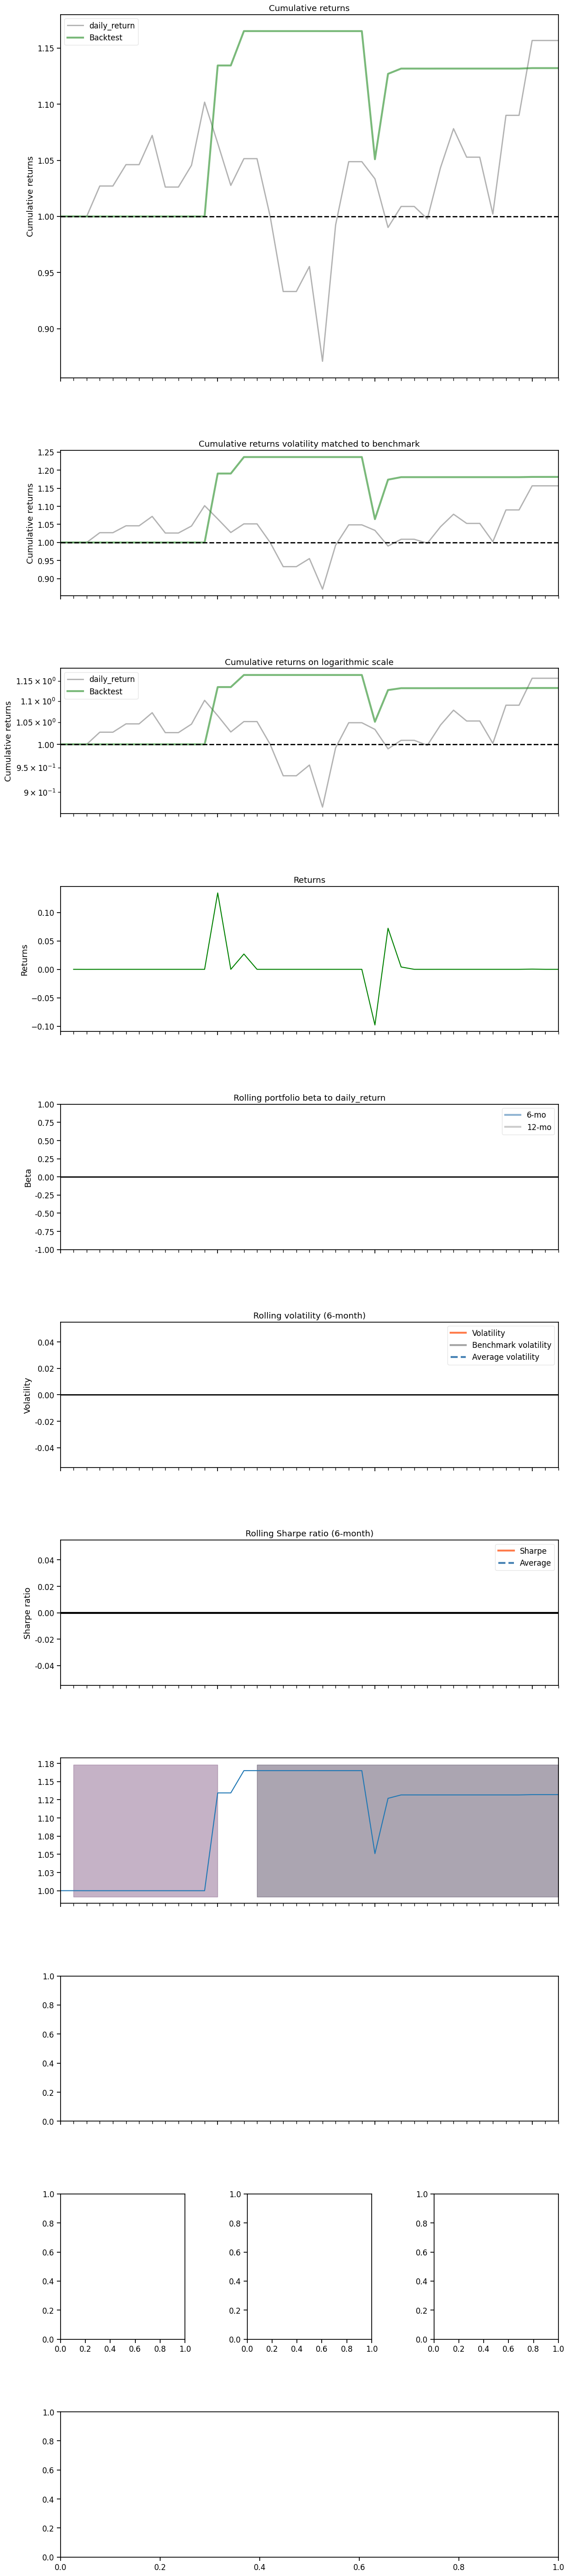

In [80]:
print("==============Compare to DJIA===========")
%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX

backtest_plot(daily_account_value, 
            baseline_ticker = '^DJI', 
            baseline_start = TEST_START_DATE,
            baseline_end = TEST_END_DATE)

### Compare to Buy&Hold Strategy
pass in df_account_value, this information is stored in env class

<a id='6.2'></a>
## 7.2 BackTest with Buy&Hold Strategy

In [130]:
# print(DOW_30_TICKER)
test_portfolio = DOW_30_TICKER[:2]
len(test_portfolio)

2

In [131]:
modify_fields = ['open','high','low','close']
used_columns = ['date','close']

In [126]:
# df_stock_test_ = get_baseline(
#         ticker='AXP', 
#         start = TEST_START_DATE,
#         end = TEST_END_DATE)
# df_stock_test_

In [127]:
# for field in modify_fields:
#     df_stock_test_[field] = df_stock_test_[field]/df_stock_test_.iloc[0][field]/len(test_portfolio)
# df_stock_test_ = df_stock_test_[used_columns]

In [132]:
daily_account_value.shape

(1058, 2)

In [153]:
#baseline stats
print("==============Get Baseline Stats===========")
shape = daily_account_value.shape
df_hold_ = pd.DataFrame(0,index=range(shape[0]), columns=range(shape[1]))
df_hold_.columns = used_columns
df_hold_['date'] = daily_account_value.date

for stock in test_portfolio:
    df_stock_ = get_baseline(
        ticker=stock, 
        start = TEST_START_DATE,
        end = TEST_END_DATE)
    # for field in modify_fields:
    if len(df_stock_) < len(df_hold_):
        final_row = df_stock_.iloc[-1]
        new_rows = pd.DataFrame([final_row] * (len(df_hold_) - len(df_stock_)))
        df_stock_ = pd.concat([df_stock_, new_rows], ignore_index=True)
        
        for i in range(0,len(df_stock_) < len(df_hold_)):
            df_stock_.iloc[en(df_stock_)] = df_stock_.iloc[len(df_stock_-1)]
    df_stock_['close'] = df_stock_['close']/df_stock_.iloc[0]['close']/len(test_portfolio)
    df_hold_['close'] = df_hold_.close + df_stock_.close

stats = backtest_stats(df_hold_, value_col_name = 'close')

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

==============Get Baseline Stats===========
Shape of DataFrame:  (1057, 8)
Shape of DataFrame:  (1057, 8)
Annual return          0.113655
Cumulative returns     0.571369
Annual volatility      0.272331
Sharpe ratio           0.530754
Calmar ratio           0.322387
Stability              0.732961
Max drawdown          -0.352541
Omega ratio            1.105579
Sortino ratio          0.796600
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.051671
Daily value at risk   -0.033737
dtype: float64


In [134]:
df_hold_

,date,close
0,2020-01-02,1.000000
1,2020-01-03,0.991639
2,2020-01-06,0.993305
3,2020-01-07,0.986016
4,2020-01-08,0.994853
...,...,...
1053,2024-03-11,1.579257
1054,2024-03-12,1.592400
1055,2024-03-13,1.591768
1056,2024-03-14,1.571369


The model' calculation encompass the entire timeframe, including non-working days. To address this, we need to determine the most appropriate method to fill up the weekend plots, for example backfilling.

In [131]:
# df_hold_.date = pd.to_datetime(df_hold_['date'])
# df_hold_ = pd.merge(df_account_value_ppo['date'],df_hold_,how='left')
# df_hold_.bfill(inplace=True)
# df_hold_

In [154]:
df_hold = pd.DataFrame()
df_hold['date'] = daily_account_value['date']
df_hold['hold'] = df_hold_['close'] / df_hold_['close'][0] * env_kwargs["initial_amount"]
# print("df_hold: ", df_hold)
# df_dji.to_csv("df_dji.csv")
df_hold = df_hold.set_index(df_hold.columns[0])
print("df_hold: ", df_hold)
# df_hold.to_csv("df_dji+.csv")

# df_account_value.to_csv('df_account_value.csv')

df_hold:                      hold
date                    
2020-01-02  1.000000e+06
2020-01-03  9.916392e+05
2020-01-06  9.933047e+05
2020-01-07  9.860160e+05
2020-01-08  9.948534e+05
...                  ...
2024-03-11  1.579257e+06
2024-03-12  1.592400e+06
2024-03-13  1.591768e+06
2024-03-14  1.571369e+06
2024-03-15  1.571369e+06

[1058 rows x 1 columns]


==============Compare to Buy&Hold===========
result:                     stock          hold
date                                  
2020-01-02  1.000000e+06  1.000000e+06
2020-01-02  9.990001e+05  1.000000e+06
2020-01-03  9.922118e+05  9.916392e+05
2020-01-03  9.922118e+05  9.916392e+05
2020-01-06  9.998330e+05  9.933047e+05
...                  ...           ...
2024-03-12  1.311546e+06  1.592400e+06
2024-03-13  1.308936e+06  1.591768e+06
2024-03-13  1.308936e+06  1.591768e+06
2024-03-14  1.287816e+06  1.571369e+06
2024-03-14  1.287816e+06  1.571369e+06

[2114 rows x 2 columns]


<Figure size 1500x500 with 0 Axes>

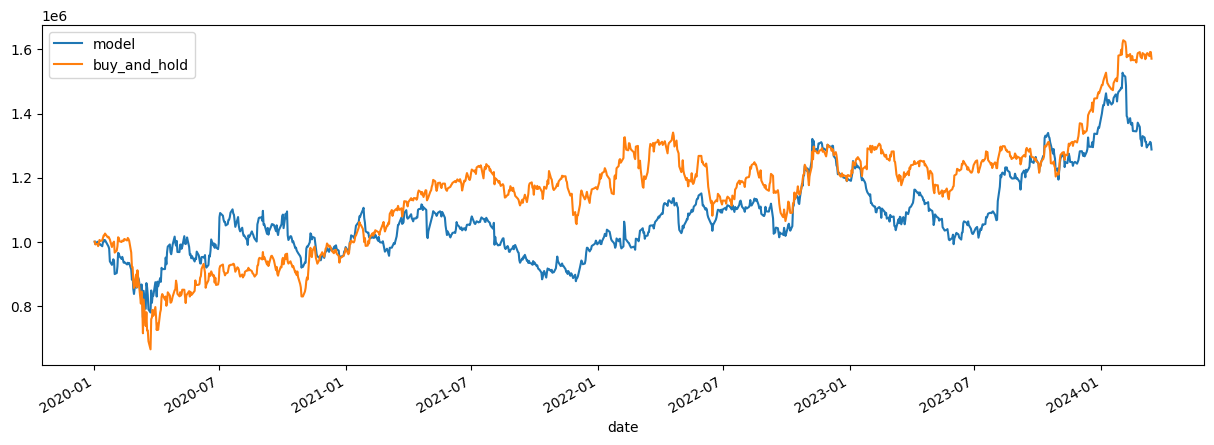

In [155]:
print("==============Compare to Buy&Hold===========")
df_result = pd.DataFrame({'date': df_account_value_ppo['date'], 'stock': df_account_value_ppo['account_value']})
df_result = df_result.set_index('date')

result = pd.DataFrame()
result = pd.merge(df_result, df_hold, left_index=True, right_index=True)
print("result: ", result)
# result.to_csv("result.csv")
result.columns = ['model', 'buy_and_hold']

%matplotlib inline
plt.rcParams["figure.figsize"] = (15,5)
plt.figure();
result.plot();

<a id='7'></a>
# 8. Save and load model #

<a id='7.1'></a>
## 8.1 Save model

### 8.1.1 Save trained model

In [59]:
import os
current_dir = os.getcwd()
print(current_dir)

/Users/admin/Desktop/GameProjects/DataScience/DeepReinforcementLearning/FinRL-Tutorials-master/6-Binhlai_Testing


In [66]:
model_name = "./"+TRAINED_MODEL_DIR+"/sp500_ppo_yearly_1024episode"
model_name

'./trained_models/sp500_ppo_yearly_1024episode'

In [67]:
trained_ppo.save(model_name)

### 8.1.2 Save model as ONNX file

In [78]:
import torch as th
import torch.onnx
from stable_baselines3 import PPO
from stable_baselines3 import SAC
from stable_baselines3 import DDPG
from stable_baselines3.common.policies import BasePolicy
from typing import Tuple

In [79]:
class OnnxableSB3Policy(th.nn.Module):
    def __init__(self, policy: BasePolicy):
        super().__init__()
        self.policy = policy

    def forward(self, observation: th.Tensor) -> Tuple[th.Tensor, th.Tensor, th.Tensor]:
        # NOTE: Preprocessing is included, but postprocessing
        # (clipping/inscaling actions) is not,
        # If needed, you also need to transpose the images so that they are channel first
        # use deterministic=False if you want to export the stochastic policy
        # policy() returns `actions, values, log_prob` for PPO
        return self.policy(observation, deterministic=True)

In [48]:
onnx_policy = OnnxableSB3Policy(trained_ppo.policy)
observation_size = trained_ppo.observation_space.shape
dummy_input = th.randn(1, *observation_size)

th.onnx.export(
    onnx_policy,
    dummy_input,
    "sac_model_1200k_sac9.onnx",
    opset_version=17,
    input_names=["input"],
)

<a id='7.2'></a>
## 8.2 Load model

### 8.2.1 Load trained model

In [46]:
from stable_baselines3 import PPO
import os
current_dir = os.getcwd()
print(current_dir)

/Users/admin/Desktop/GameProjects/DataScience/DeepReinforcementLearning/FinRL-Tutorials-master/6-Binhlai_Testing


In [65]:
model_name = "./"+TRAINED_MODEL_DIR+"/sp500_ppo_yearly_1024episode"
model_name

'./trained_models/sp500_ppo_yearly_1024episode'

In [48]:
trained_model = PPO.load(model_name)

Continous training based on the previous model

In [59]:
ratio_list = train_data.columns.drop(['date','tic','close'])
action_dimension = 1 # k float in range (-1,1) to decide sell (k<0) or buy (k>0) decisions
state_space = 1 + 4*action_dimension + len(ratio_list)
print(f"Action Dimension: {action_dimension}, State Space: {state_space}")

episode_length = len(train_data)
episode_amount = 256
total_training_step = episode_length*episode_amount

Action Dimension: 1, State Space: 22


In [57]:
# Parameters for the environment
env_kwargs = {
    "hmax": 100, 
    "initial_amount": 1000000, 
    "buy_cost_pct": 0.001,
    "sell_cost_pct": 0.01,
    "state_space": state_space, 
    "tech_indicator_list": ratio_list, 
    "action_space": action_dimension, 
    "reward_scaling": 1e-4,
    "stop_loss": 0.3,
    "print_verbosity":4,
    "punishment_rate": 0.01
}

#Establish the training environment using StockTradingEnv() class
e_train_gym = StockTradingEnv(df = train_data, **env_kwargs)
env_train, _ = e_train_gym.get_sb_env()
agent = DRLAgent(env = env_train)
trained_model.env = env_train

In [64]:
trained_ppo = agent.train_model(model=trained_ppo, 
                             tb_log_name='ppo',
                             total_timesteps=total_training_step)

Logging to tensorboard_log/test_ppo/ppo_29
---------------------------------
| time/              |          |
|    fps             | 625      |
|    iterations      | 1        |
|    time_elapsed    | 3        |
|    total_timesteps | 2048     |
| train/             |          |
|    reward          | 157.1141 |
---------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 543           |
|    iterations           | 2             |
|    time_elapsed         | 7             |
|    total_timesteps      | 4096          |
| train/                  |               |
|    approx_kl            | 1.6309787e-07 |
|    clip_fraction        | 0             |
|    clip_range           | 0.1           |
|    entropy_loss         | -1.61         |
|    explained_variance   | -7.62e-05     |
|    learning_rate        | 0.00025       |
|    loss                 | 4.36e+05      |
|    n_updates            | 23020  

#### Test loaded model

In [ ]:
test_env = StockTradingEnv(df = trade_data, **env_kwargs)

In [ ]:
test_step = 1000
test_result = []
test_env.reset()
for i in range(0,test_step):
    observation = [test_env.state]
    observation = np.array(observation).astype(np.float32)
    actions, values, log_prob = ort_sess.run(None, {"input": observation})
    result = test_env.step(actions)
    test_result.append(result[1])
    if result[2] == True:
        break

### 8.2.2 Load ONNX model

In [ ]:
import onnx
import onnxruntime as ort
import numpy as np

In [ ]:
onnx_path = "all_in_one_ppo.onnx"
onnx_model = onnx.load(onnx_path)
onnx.checker.check_model(onnx_model)

# # Check that the predictions are the same
# with th.no_grad():
#     print(model.policy(th.as_tensor(observation), deterministic=True))

In [ ]:
observation = np.zeros((1, state_space)).astype(np.float32)
ort_sess = ort.InferenceSession(onnx_path)
actions, values, log_prob = ort_sess.run(None, {"input": observation})
print(actions, values, log_prob)